In [2]:
import sympy
import torch
import kan

In [2]:
f = sympy.Function('hi')
f

hi

In [4]:
f('x')

hi(x)

In [6]:
g = lambda x : torch.tanh(x)

In [10]:
g.__code__

<code object <lambda> at 0x0000026C0C90FC30, file "C:\Users\taoha\AppData\Local\Temp\ipykernel_36368\259579469.py", line 1>

In [11]:
g.__name__

'<lambda>'

In [14]:
f'{g=}'.split('=')[0]

'g'

In [17]:
import inspect
lines = inspect.getsource(g)
print(lines)

g = lambda x : torch.tanh(x)



In [20]:
fstr = f'{(lambda x : torch.tanh(x))=}'.split('=')[0]
fstr

'(lambda x : torch.tanh(x))'

In [24]:
sympy.Function(fstr)('x') + 1

(lambda x : torch.tanh(x))(x) + 1

In [9]:
def f(x):
    return x[:, 0]
import kan.utils as ku
dataset = ku.create_dataset(f, train_num = 10, test_num = 2)

In [24]:
kan_model = kan.KAN(width=[1, 1])
kan_model(dataset['train_input'])
tanh = lambda x : torch.tanh(x)
kan_model.fix_symbolic(0, 0, 0, tanh)
# kan_model.fix_symbolic(0, 0, 0, lambda x : torch.tanh(x))

checkpoint directory created: ./model
saving model version 0.0
saving model version 0.1


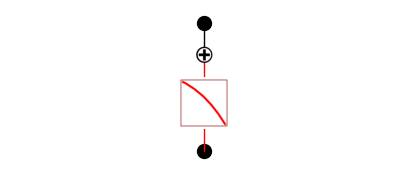

In [25]:
kan_model.plot()

In [26]:
import dill
import inspect
def symbolic_formula(self, var=None, normalizer=None, output_normalizer = None):
    '''
    get symbolic formula

    Args:
    -----
        var : None or a list of sympy expression
            input variables
        normalizer : [mean, std]
        output_normalizer : [mean, std]
        
    Returns:
    --------
        None

    Example
    -------
    >>> from kan import *
    >>> model = KAN(width=[2,1,1], grid=5, k=3, noise_scale=0.0, seed=0)
    >>> f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]])+x[:,[1]]**2)
    >>> dataset = create_dataset(f, n_var=3)
    >>> model.fit(dataset, opt='LBFGS', steps=20, lamb=0.001);
    >>> model.auto_symbolic()
    >>> model.symbolic_formula()[0][0]
    '''
    
    symbolic_acts = []
    symbolic_acts_premult = []
    x = []

    def ex_round(ex1, n_digit):
        ex2 = ex1
        for a in sympy.preorder_traversal(ex1):
            if isinstance(a, sympy.Float):
                ex2 = ex2.subs(a, round(a, n_digit))
        return ex2

    # define variables
    if var == None:
        for ii in range(1, self.width[0][0] + 1):
            exec(f"x{ii} = sympy.Symbol('x_{ii}')")
            exec(f"x.append(x{ii})")
    elif isinstance(var[0], sympy.Expr):
        x = var
    else:
        x = [sympy.symbols(var_) for var_ in var]

    x0 = x

    if normalizer != None:
        mean = normalizer[0]
        std = normalizer[1]
        x = [(x[i] - mean[i]) / std[i] for i in range(len(x))]

    symbolic_acts.append(x)

    for l in range(len(self.width_in) - 1):
        num_sum = self.width[l + 1][0]
        num_mult = self.width[l + 1][1]
        y = []
        for j in range(self.width_out[l + 1]):
            yj = 0.
            for i in range(self.width_in[l]):
                a, b, c, d = self.symbolic_fun[l].affine[j, i]
                sympy_fun = self.symbolic_fun[l].funs_sympy[j][i]
                try:
                    yj += c * sympy_fun(a * x[i] + b) + d
                except:
                    print(sympy_fun)
                    print(inspect.getsource(sympy_fun))
                    print(dill.source.getsource(sympy_fun))
                    print(f'{sympy_fun=}')
                    print(f'{self.symbolic_fun[l].funs_sympy[j][i]=}')
                    print(f'{sympy_fun=}'.split('=')[0])
                    # sympy_fun = sympy.Function(f'{sympy_fun=}'.split('=')[0])
                    sympy_fun = sympy.Function(f'({inspect.getsource(sympy_fun)})')
                    yj += c * sympy_fun(a * x[i] + b) + d
                    # yj += c * sympy.tanh(a * x[i] + b) + d
                    print('make sure all activations need to be converted to symbolic formulas first!')
                    # return
            yj = self.subnode_scale[l][j] * yj + self.subnode_bias[l][j]
            y.append(yj)
                
        symbolic_acts_premult.append(y)
            
        mult = []
        for k in range(num_mult):
            if isinstance(self.mult_arity, int):
                mult_arity = self.mult_arity
            else:
                mult_arity = self.mult_arity[l+1][k]
            for i in range(mult_arity-1):
                if i == 0:
                    mult_k = y[num_sum+2*k] * y[num_sum+2*k+1]
                else:
                    mult_k = mult_k * y[num_sum+2*k+i+1]
            mult.append(mult_k)
            
        y = y[:num_sum] + mult
        
        for j in range(self.width_in[l+1]):
            y[j] = self.node_scale[l][j] * y[j] + self.node_bias[l][j]
        
        x = y
        symbolic_acts.append(x)

    if output_normalizer != None:
        output_layer = symbolic_acts[-1]
        means = output_normalizer[0]
        stds = output_normalizer[1]

        assert len(output_layer) == len(means), 'output_normalizer does not match the output layer'
        assert len(output_layer) == len(stds), 'output_normalizer does not match the output layer'
        
        output_layer = [(output_layer[i] * stds[i] + means[i]) for i in range(len(output_layer))]
        symbolic_acts[-1] = output_layer


    self.symbolic_acts = [[symbolic_acts[l][i] for i in range(len(symbolic_acts[l]))] for l in range(len(symbolic_acts))]
    self.symbolic_acts_premult = [[symbolic_acts_premult[l][i] for i in range(len(symbolic_acts_premult[l]))] for l in range(len(symbolic_acts_premult))]

    out_dim = len(symbolic_acts[-1])
    #return [symbolic_acts[-1][i] for i in range(len(symbolic_acts[-1]))], x0
    return [symbolic_acts[-1][i] for i in range(len(symbolic_acts[-1]))], x0

In [27]:
symbolic_formula(kan_model)[0][0]

<function <lambda> at 0x000001CD226DFCE0>
tanh = lambda x : torch.tanh(x)

tanh = lambda x : torch.tanh(x)

sympy_fun=<function <lambda> at 0x000001CD226DFCE0>
self.symbolic_fun[l].funs_sympy[j][i]=<function <lambda> at 0x000001CD226DFCE0>
sympy_fun
make sure all activations need to be converted to symbolic formulas first!


1.0*(tanh = lambda x : torch.tanh(x)
)(1.0*x_1)